In [850]:
import pandas as pd
import seaborn as sns
import numpy as np

In [851]:
from ucimlrepo import fetch_ucirepo

iris = fetch_ucirepo(id=53)

In [852]:
TARGET = "class"

X = iris.data.features
y = iris.data.targets
df = pd.concat([X, y], axis=1)

In [853]:
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [854]:
def draw_heat_map(corr_matrix: pd.DataFrame) -> None:
    sns.heatmap(data=corr_matrix, cmap='coolwarm', annot=True, annot_kws={"fontsize": 5.5})

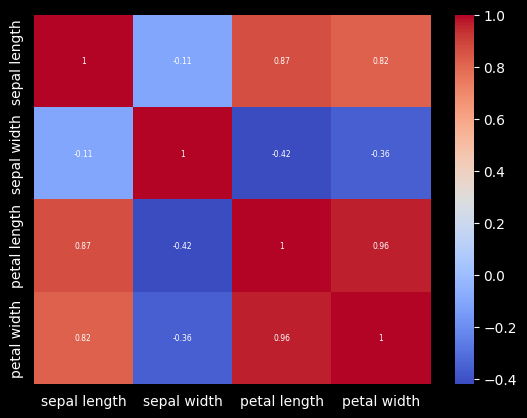

In [855]:
draw_heat_map(X.corr())

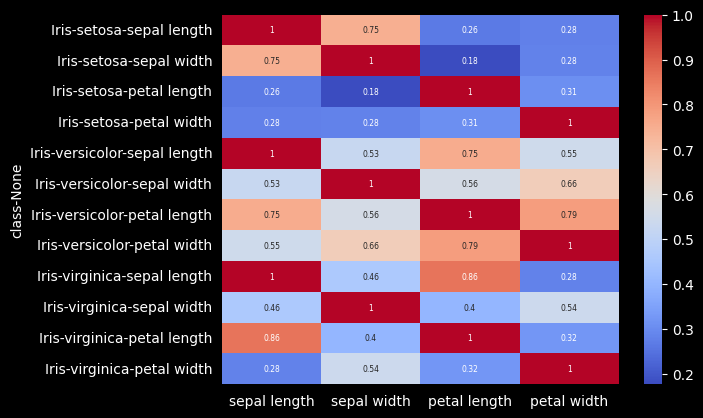

In [856]:
draw_heat_map(df.groupby(TARGET).corr())


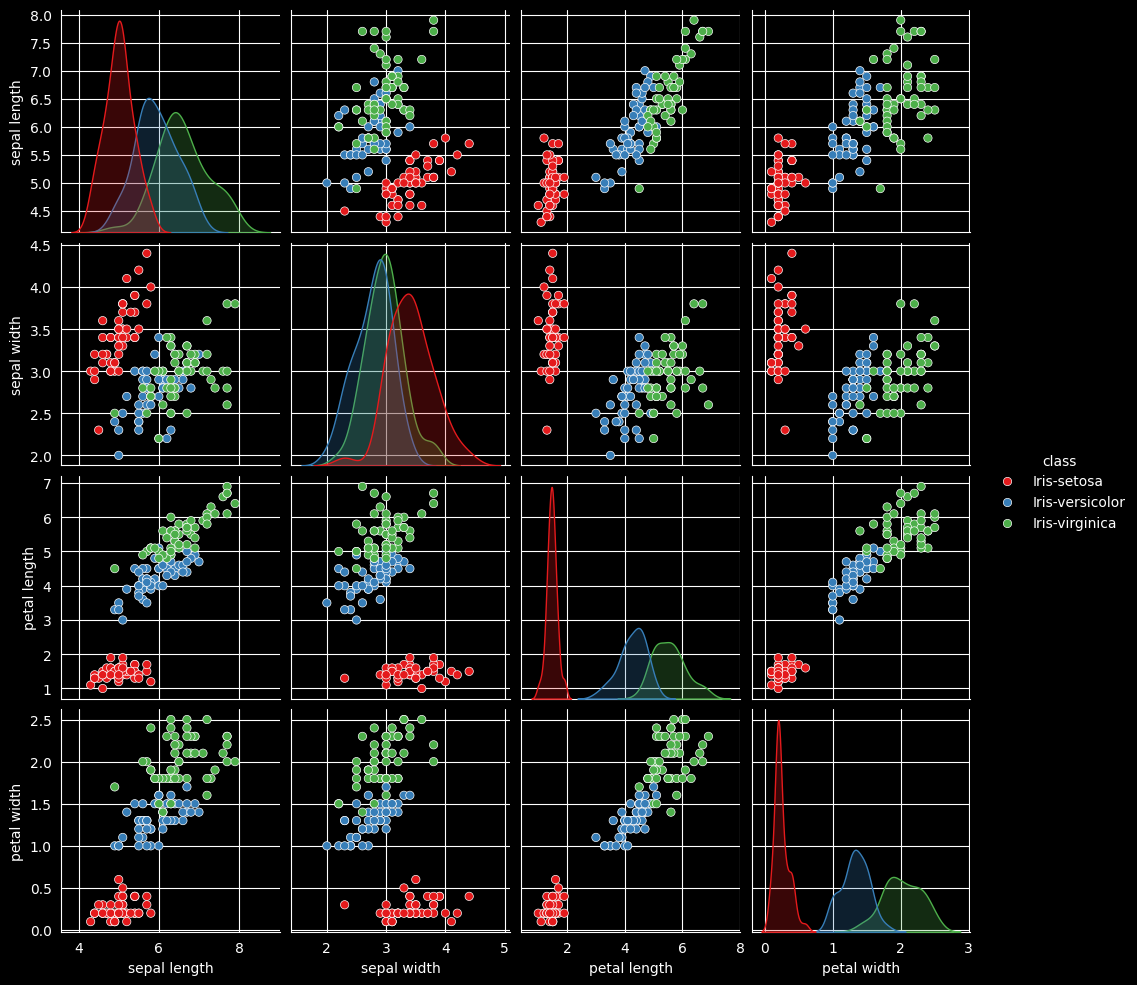

In [857]:
sns.pairplot(df, hue=TARGET, palette="Set1")

In [858]:
TWO_VARIABLES = ["petal length", "petal width"]

variables_to_drop = []

for c in df.columns:
    if c not in TWO_VARIABLES:
        variables_to_drop.append(c)

X_TWO_variables = df.drop(variables_to_drop, axis=1)


In [859]:
from sklearn.preprocessing import LabelEncoder

y_values = y[TARGET]
le = LabelEncoder()
le.fit(y_values)
y_values_encoded = le.transform(y_values)


In [860]:
class MyQDA:
    def __init__(self):
        self.__n_classes = -1
        self.__means = None
        self.__norms = None
        self.__inverted_covs = None
        self.__freqs = None

    def __repr__(self) -> str:
        return "MyQDA()"

    def fit(self, X, y):
        n_features = X.shape[1]
        unique_classes = np.unique(y)
        n_classes = len(unique_classes)
        x_by_classes = [X[y == c] for c in unique_classes]

        self.__n_classes = n_classes
        self.__means = np.empty((n_classes, n_features))
        self.__freqs = np.empty(n_classes)
        self.__norms = np.empty(n_classes)
        self.__inverted_covs = np.empty((n_classes, n_features, n_features))

        for i in range(n_classes):
            current_x = x_by_classes[i]
            x_cov = np.cov(current_x, rowvar=False)
            self.__means[i] = np.mean(current_x, axis=0)
            self.__freqs[i] = len(current_x) / len(X)
            self.__norms[i] = np.linalg.norm(x_cov)
            self.__inverted_covs[i] = np.linalg.inv(x_cov)

    def predict_proba(self, X) -> np.ndarray:
        if len(X.shape) == 1:
            x_size = 1
            X = X.reshape(1, -1)
        else:
            x_size = X.shape[0]

        deltas = np.empty((x_size, self.__n_classes))

        for i in range(self.__n_classes):
            mean = self.__means[i]
            norm = self.__norms[i]
            inv = self.__inverted_covs[i]
            freq = self.__freqs[i]

            delta = -1/2 * (np.log(norm) + np.sum(((X - mean) @ inv) * (X - mean), axis=1)) + np.log(freq)

            deltas[:, i] = delta

        return np.exp(deltas) / np.exp(deltas).sum(axis=1).reshape(-1, 1)  # softmax

    def predict(self, X) -> np.ndarray:
        return self.predict_proba(X).argmax(axis=1)

    def score(self, X, y) -> float:
        if len(X.shape) == 1:
            x_size = 1
        else:
            x_size = X.shape[0]

        predictions = self.predict(X)

        return np.count_nonzero(predictions == y) / x_size


In [861]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

models = [
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MyQDA(),
    LogisticRegression(),
    SVC(kernel="poly", degree=1),
    SVC(kernel="poly", degree=2),
]

for m in models:
    m.fit(X_TWO_variables.values, y_values_encoded)
    print(f"{m}: {m.score(X_TWO_variables.values, y_values_encoded)}")


LinearDiscriminantAnalysis(): 0.96
QuadraticDiscriminantAnalysis(): 0.98
MyQDA(): 0.9666666666666667
LogisticRegression(): 0.9666666666666667
SVC(degree=1, kernel='poly'): 0.96
SVC(degree=2, kernel='poly'): 0.9666666666666667


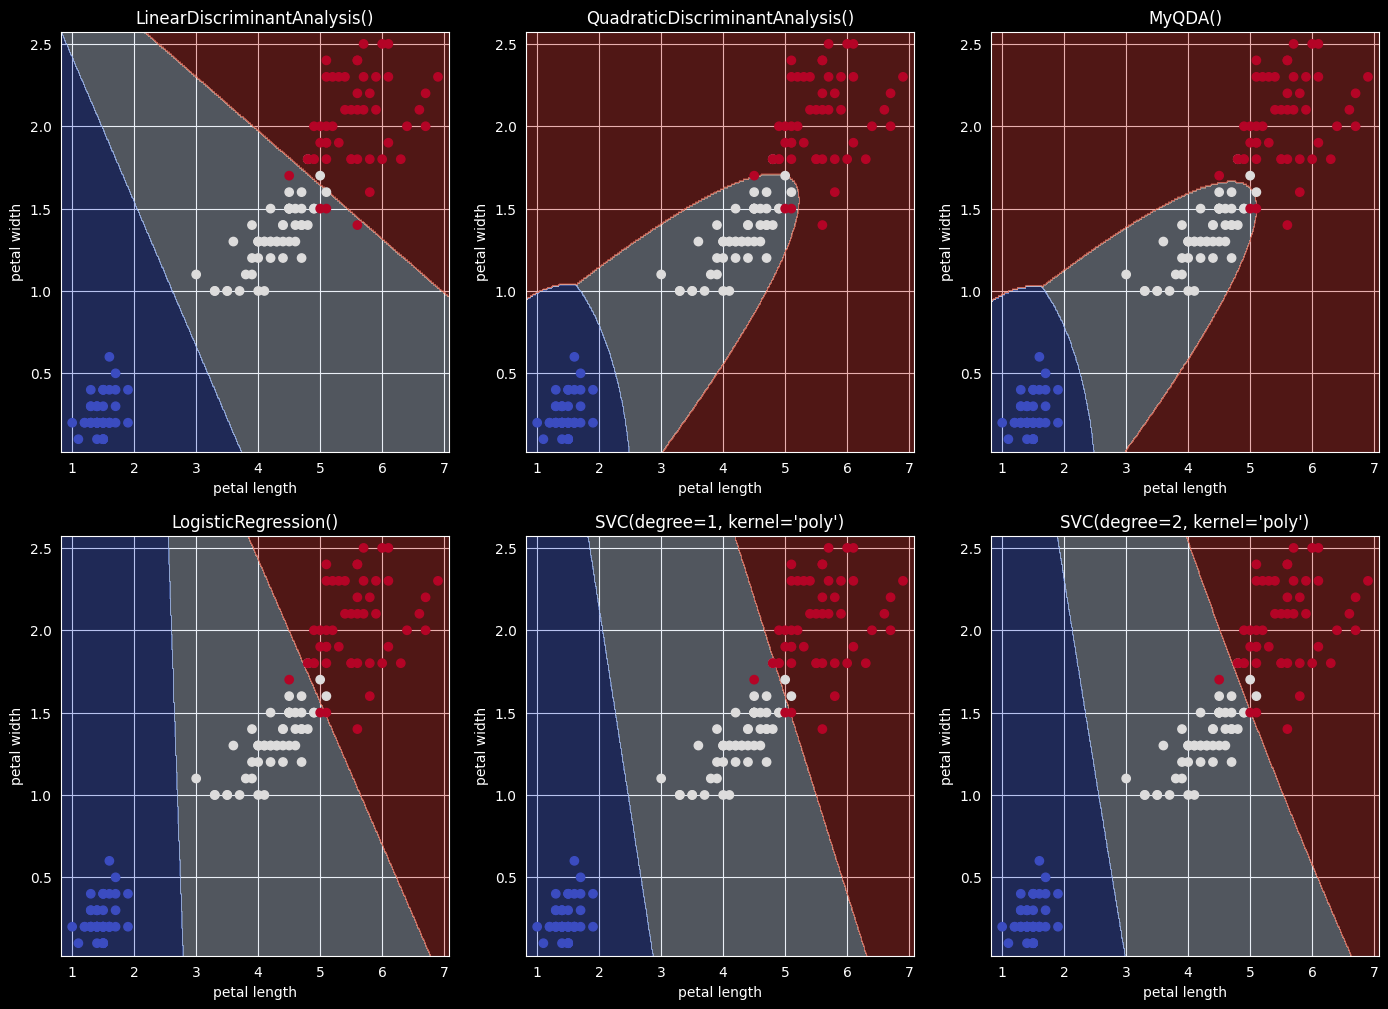

In [862]:
import matplotlib.pyplot as plt

def get_grid(data_x, data_y, padding_k=0.0, h=0.01):
    padding_x = data_x.std() * padding_k
    padding_y = data_y.std() * padding_k
    x_min, x_max = data_x.min() - padding_x, data_x.max() + padding_x
    y_min, y_max = data_y.min() - padding_y, data_y.max() + padding_y
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    return xx, yy

x_values = X_TWO_variables[TWO_VARIABLES[0]].to_numpy()
y_values = X_TWO_variables[TWO_VARIABLES[1]].to_numpy()

grid_x, grid_y = get_grid(x_values, y_values, padding_k=0.1)
grid = np.c_[grid_x.ravel(), grid_y.ravel()]
fig, sub = plt.subplots(2, 3,figsize=(17,12))

for m, ax in zip(models, sub.flatten()):
    ax.contourf(grid_x, grid_y, m.predict(grid).reshape(grid_x.shape), cmap="coolwarm", alpha=0.4)
    ax.scatter(x_values, y_values, c=y_values_encoded, cmap="coolwarm")
    ax.set_title(m)
    ax.set_xlabel("petal length")
    ax.set_ylabel("petal width")

plt.show()


In [863]:
lda = LinearDiscriminantAnalysis()
lda.fit(X.values, y_values_encoded)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [864]:
df["encoded"] = y_values_encoded
df["predicted"] = lda.predict(X.values)
df["correct"] = df["encoded"] == df["predicted"]
df["predicted_class"] = df[TARGET] + "_" + df["correct"].astype(str)
df.drop(labels=["encoded", "predicted", "correct"], axis=1, inplace=True)

print(df["predicted_class"].value_counts())


predicted_class
Iris-setosa_True         50
Iris-virginica_True      49
Iris-versicolor_True     48
Iris-versicolor_False     2
Iris-virginica_False      1
Name: count, dtype: int64


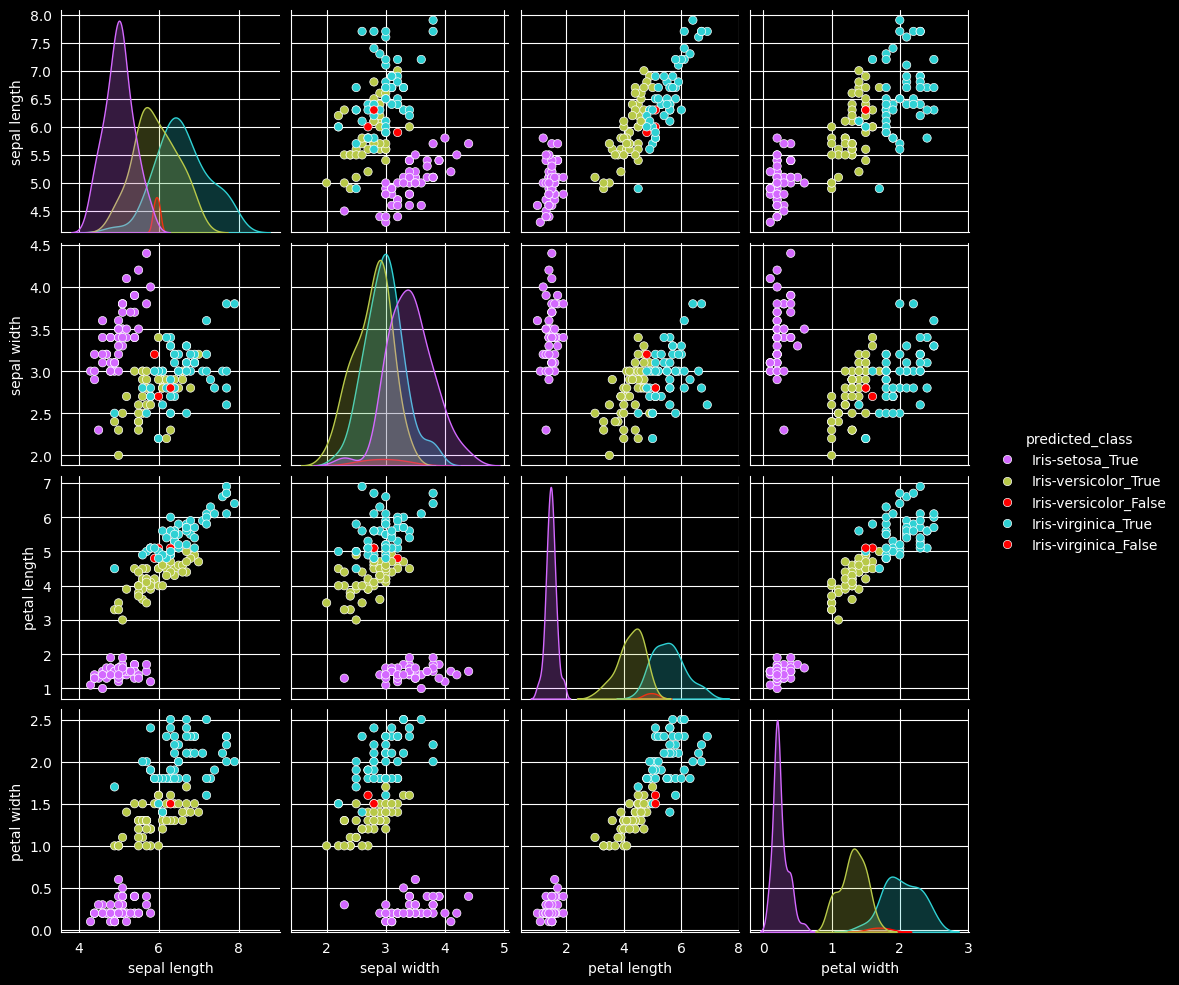

In [865]:
RED = "#ff0000"

palette = {
    'Iris-setosa_True': '#d469ff',
    'Iris-versicolor_True': '#b8c949',
    "Iris-virginica_True": "#2fd1d4",
    "Iris-virginica_False": RED,
    "Iris-versicolor_False": RED,
}

sns.pairplot(df, vars=iris.feature_names, hue="predicted_class", palette=palette)
